# Movie Color Chart Creator

### MadMax trailer ColorChart

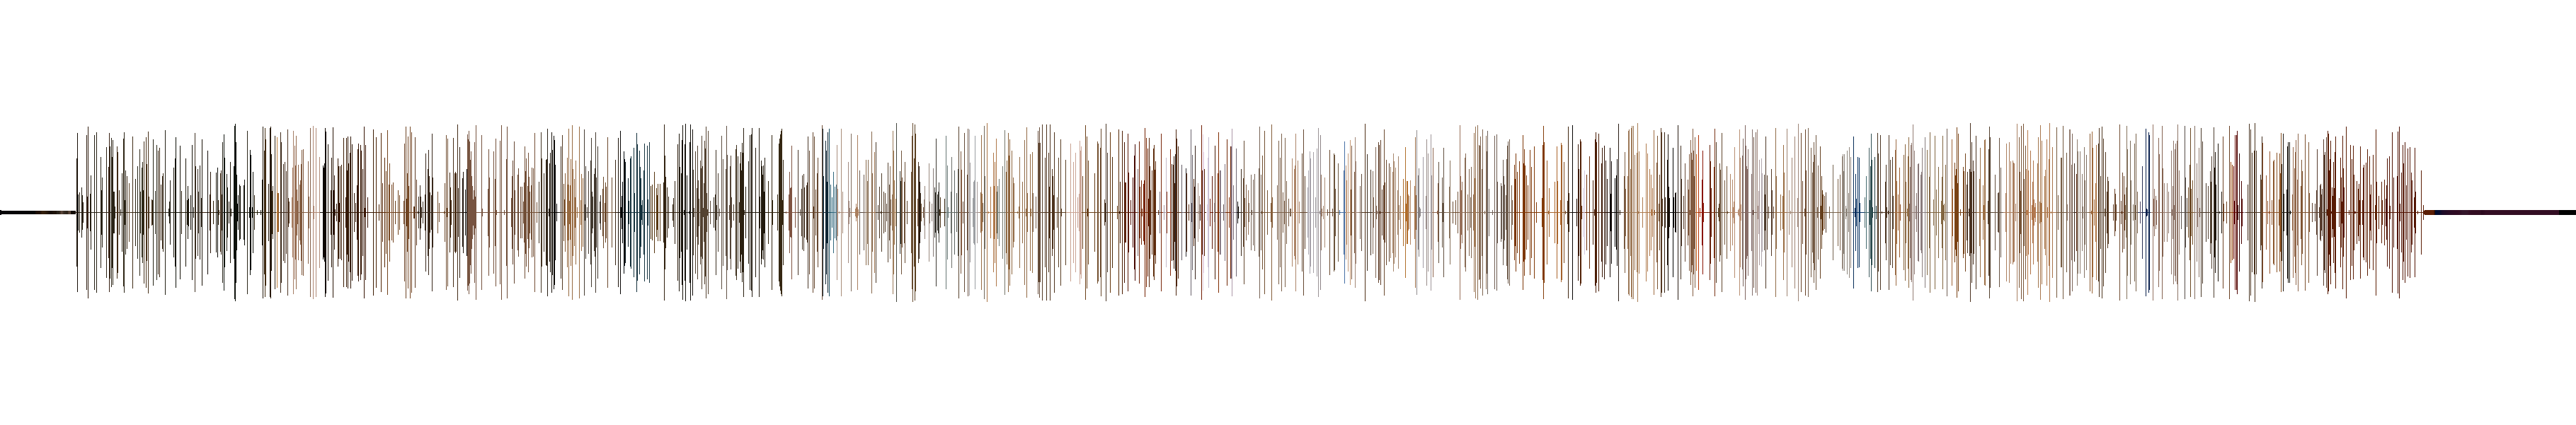

In [89]:
import os 
import pafy
import cv2
import numpy as np

## Define URL

In [90]:
url = ("https://www.youtube.com/watch?v=mtolAJbj44s&ab_channel=WarnerBros.France", "MadMax 3 Trailer")
#url = ("https://www.youtube.com/watch?v=8Qn_spdM5Zg&ab_channel=StarWars", "StarWars 9")
#url = ("https://www.youtube.com/watch?v=Qp91xlsaKSo&ab_channel=FulcrumFanEdits", "StarWars ObiWan vs Dark Maul")
#url = ("https://www.youtube.com/watch?v=kUd2DLfwYk8&ab_channel=TopMoments", "Harry Potter last battle")
#url = ("https://www.youtube.com/watch?v=HX7OGWWh7ZI&ab_channel=TopMoments", "HarryPotter Dumbledore vs Voldemort")
#url = ("https://www.youtube.com/watch?v=eU9JRYzUBBg&ab_channel=SebastianSamuel", "Dark Vador vs Ahsoka")
#url = ("https://www.youtube.com/watch?v=OMOVFvcNfvE&ab_channel=MovieclipsTrailers", "StarWars-ForceAwaken")
#url = ("https://www.youtube.com/watch?v=caHnaRq8Qlg&ab_channel=N.B.", "MadMax 1 Trailer")
#url = ("https://www.youtube.com/watch?v=m5hyLg7yZtI&ab_channel=WarnerBros.France", "MadMax 2 Trailer")

In [91]:
# https://towardsdatascience.com/finding-most-common-colors-in-python-47ea0767a06a

In [92]:
vPafy = pafy.new(url[0])
play = vPafy.getbest(preftype="mp4")

## Extract values

In [93]:
def extract_high_frequency(frame):
    frame = cv2.resize(frame, (160,160), interpolation = cv2.INTER_AREA)
    unique, counts = np.unique(frame.reshape(-1, 3), axis=0, return_counts=True)
    if len(unique) > 1:
        pixel = tuple(unique[np.where(counts == np.sort(counts)[-2])[0][0]])
        frame_dict_highest_freq[frame_cpt_high_freq] = (pixel[2], pixel[1], pixel[0])

In [94]:
frame_dict_mean: dict = dict()
frame_dict_median: dict = dict()
frame_dict_highest_freq: dict = dict()

In [95]:
cap = cv2.VideoCapture(play.url)

In [96]:
ret,frame = cap.read()
frame_reshape_size = (int(frame.shape[0]/2), int(frame.shape[1]/2))

In [97]:
frame_cpt = 0
frame_cpt_high_freq = 0

while (True):
    ret,frame = cap.read()
    
    if ret:
        frame = cv2.resize(frame, frame_reshape_size)
        frame = frame.reshape(-1, 3)
        
        # Remove pixels at [0, 0, 0]
        frame = frame[np.delete(np.array(range(len(frame))), np.where(~np.any(frame, axis=1))[0])]       
        # Remove pixels at [1, 1, 1]
        frame = frame[~(frame == 1).all(axis=1)]
        
        if frame.shape[0] != 0:
            frame_dict_mean[frame_cpt] = (np.uint8(np.mean(frame[:,2])), np.uint8(np.mean(frame[:,1])), np.uint8(np.mean(frame[:,0])))
            frame_dict_median[frame_cpt] = (np.median(frame[:,2]), np.median(frame[:,1]), np.median(frame[:,0]))
            frame_cpt += 1

        """
        frame = cv2.resize(frame, (160,160), interpolation = cv2.INTER_AREA)
        unique, counts = np.unique(frame.reshape(-1, 3), axis=0, return_counts=True)
        if len(unique) > 1:
            pixel = tuple(unique[np.where(counts == np.sort(counts)[-2])[0][0]])
            frame_dict_highest_freq[frame_cpt_high_freq] = (pixel[2], pixel[1], pixel[0])
            frame_cpt_high_freq += 1
        """
        
    else:
        break
    
    cv2.waitKey(1)

cap.release()

print('End of extraction')

End of extraction


## Create ColorChart

In [108]:
from PIL import Image
from matplotlib import pyplot as plt
from skimage.color import rgb2lab
from sklearn.cluster import KMeans

In [99]:
def dict_to_image(dict_img):
    img_array = np.zeros(shape=(601, len(dict_img), 3))
    
    for pixel_key, pixel_value in dict_img.items():
        img_array[:,pixel_key,:] = pixel_value
    
    img_array = img_array.astype(np.uint8)
    return Image.fromarray(img_array)

In [100]:
def dict_to_sorted_image(dict_img):
    dict_img_lab: dict = dict()    
        
    for id, colors in dict_img.items():
        dict_img_lab[id] = rgb2lab([[[colors]]])[0][0][0]
        
    dict_img_lab = dict(sorted(dict_img_lab.items(), key=lambda item: item[1][0]))
    
    frame_dict_mean_sorted: dict = dict()
    for key_lab, key_rgb in zip(dict_img_lab.keys(), dict_img.keys()):
        frame_dict_mean_sorted[key_rgb] = dict_img[key_lab] 
    
    return frame_dict_mean_sorted

In [139]:
def kmean_from_dict(dict_img, clusters=5, show_pie=False):
    kmeans=KMeans(n_clusters=clusters)
    s=kmeans.fit(np.array([i for i in dict_img.values()]))
    centroid=kmeans.cluster_centers_
    labels=list(kmeans.labels_)
    
    kmean_dict: dict = dict()
    for colors, i in zip(centroid, range(len(centroid))):
        kmean_dict[i]=colors
    
    percent: list = list()    
    for i in range(len(centroid)):
      j=labels.count(i)
      j=j/(len(labels))
      percent.append(j)
    
    if show_pie:
        plt.pie(percent,colors=np.array(centroid/255),labels=np.arange(len(centroid)))
        plt.show()
    
    return kmean_dict

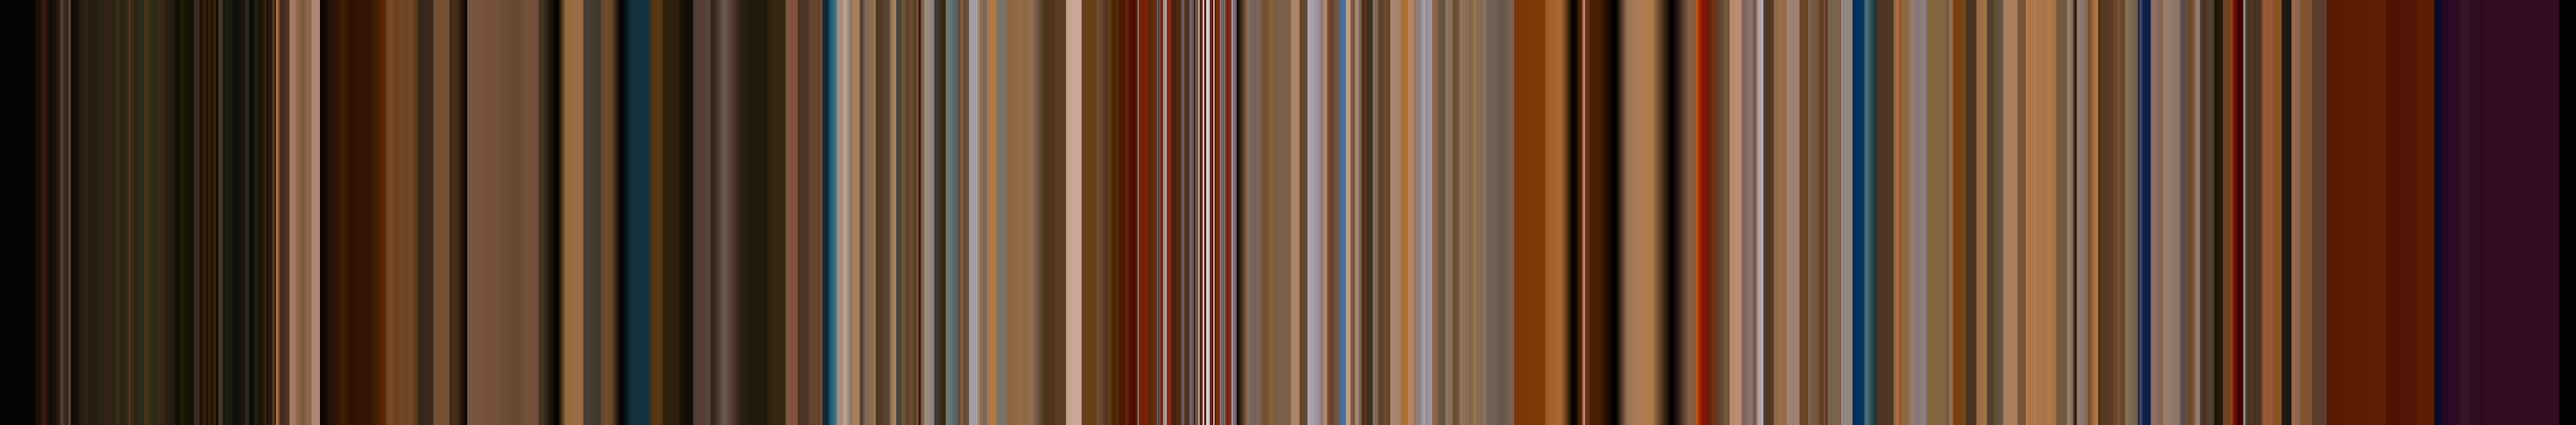

In [140]:
image_mean = dict_to_image(frame_dict_mean)
image_mean

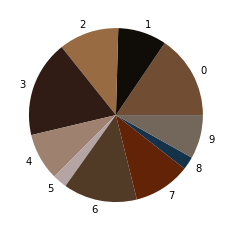

In [144]:
frame_dict_mean_kmean = kmean_from_dict(frame_dict_mean, clusters=10, show_pie=True)

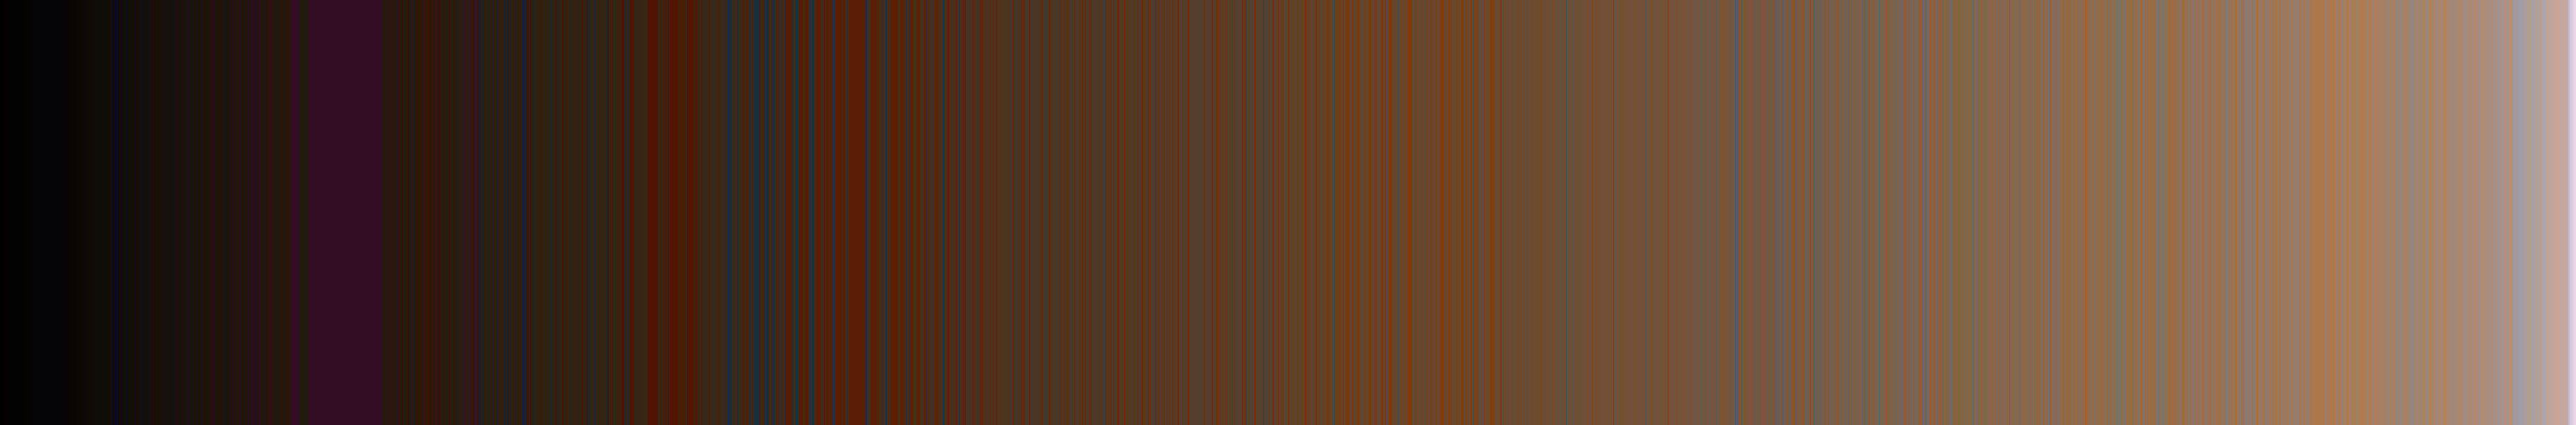

In [142]:
image_mean_sorted = dict_to_sorted_image(frame_dict_mean)
image_mean_sorted = dict_to_image(image_mean_sorted)
image_mean_sorted

In [106]:
image_median = dict_to_image(frame_dict_median)
#image_median

In [107]:
image_median_sorted = dict_to_sorted_image(frame_dict_median)
image_median_sorted = dict_to_image(image_median_sorted)
#image_median_sorted

In [14]:
def save_image(img, title):
    img.save(title)

In [15]:
save_image(image_median, url[1] + ' - Median ColorChart.png')
save_image(image_mean, url[1] +  ' - Mean ColorChart.png')

# Extract sound from video

###### python -m pip install git+https://github.com/pytube/pytube

In [16]:
import pytube
import moviepy.editor as mp
import librosa

In [17]:
youtube = pytube.YouTube(url[0])
video = youtube.streams.get_highest_resolution()
file = video.download(os.path.join(os.path.abspath(os.getcwd()), 'Videos'))

In [18]:
clip = mp.VideoFileClip(file)

In [19]:
audioFile = os.path.splitext(file)[0] + '.wav'
clip.audio.write_audiofile(audioFile)

chunk:  23%|█████████████▊                                              | 459/1988 [00:00<00:00, 1878.81it/s, now=None]

MoviePy - Writing audio in C:\Work\Projets\MovieColorChart\Videos\Star Wars The Force Awakens Official Teaser Trailer 1 (2015) - JJ Abrams Movie HD.wav


MoviePy - Done.


In [20]:
import wave
from matplotlib import pyplot as plt

In [29]:
raw = wave.open(audioFile)
signal = raw.readframes(-1)
signal = np.frombuffer(signal, dtype ="int16") # real audio signal is here

In [30]:
# Simplify signal
signal = signal[range(0, len(signal), int(len(signal) / len(frame_dict_mean)))] + 10
signal = signal[:-1]
signal = (signal / 2).astype(np.int8)

In [31]:
print('Signal length:', len(signal))
print('Image shape:', image_mean.width, image_mean.height)

Signal length: 1477
Image shape: 1477 601


In [32]:
def signal_to_image(signal, image):
    
    img = np.zeros(shape=(image.height, image.width))
    mid_point = int(image.height / 2)
    img[mid_point,:] = 255
    
    for value, row in zip(signal, range(image.size[0])):    
        indexes = (range(0, img.shape[0], 1) if mid_point - value < 0 else range(mid_point - value + 1, mid_point + value, 1))   
        img[indexes, row] = 255
    
    img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    img = img.astype(np.uint8)
    
    return Image.fromarray(img)

In [33]:
def setAlpha_to_signalImage(image):
    
    image = image.convert("RGBA")

    width, height = image.size
    pixdata = image.load()

    for y in range(height):
        for x in range(width):
                if pixdata[x, y] == (0, 0, 0, 255):
                    image.putpixel((x, y), (0, 0, 0, 0))
                    
    return image

In [34]:
signal_image = signal_to_image(signal, image_mean)
signal_image = setAlpha_to_signalImage(signal_image)

In [35]:
from PIL import ImageChops

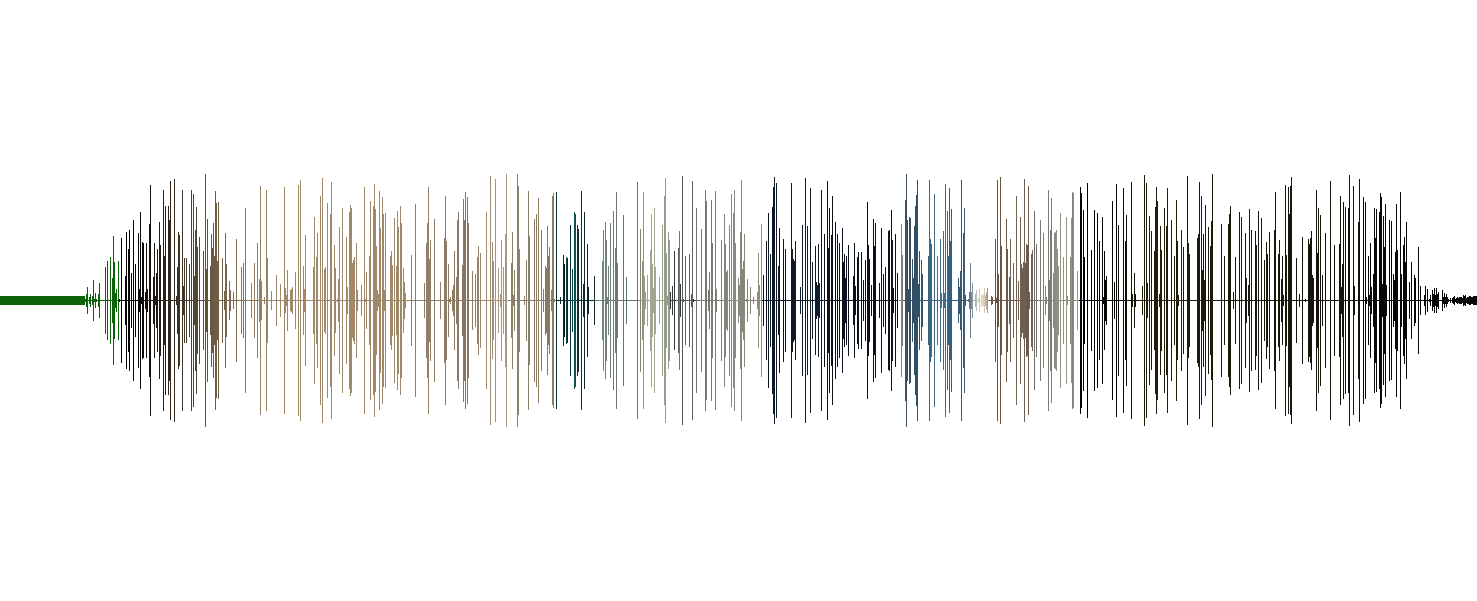

In [36]:
image_mean = image_mean.convert("RGBA")
signal_image = signal_image.convert("RGBA")

combine_image = ImageChops.multiply(image_mean, signal_image)
combine_image = combine_image.convert("RGBA")
combine_image

In [ ]:
save_image(combine_image, url[1] +  ' - ColorChart.png')